## Imports and Helper Functions
Download the dataset from https://www.kaggle.com/yelp-dataset/yelp-dataset
Put csvs in `Trane-Aux/yelp-dataset/`

In [1]:
import sys
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt

path_to_datasets = 'yelp-dataset/'

def save_obj(obj, name):
    with open('pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open('pickled_objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def generate_probs_and_nl(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    nl_descrips = trane.generate_nl_description(
        probs, table_meta, entity_id_column, label_generating_column, time_column, trane.ConstantIntegerCutoffTimes(0))
    return probs, nl_descrips
def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

## Load, Format and Sample Data

In [2]:
yelp_review_df = pd.read_csv(path_to_datasets + 'yelp_review.csv')
yelp_checkin_df = pd.read_csv(path_to_datasets + 'yelp_checkin.csv')
yelp_business_df = pd.read_csv(path_to_datasets + 'yelp_business.csv')
yelp_user_df = pd.read_csv(path_to_datasets + 'yelp_user.csv')

sampled_yelp_review_df = yelp_review_df.head(1000)
sampled_business_ids = sampled_yelp_review_df['business_id'].unique()
sampled_user_ids = sampled_yelp_review_df['user_id'].unique()
sampled_review_ids = sampled_yelp_review_df['review_id'].unique()
sampled_yelp_checkin_df = yelp_checkin_df[yelp_checkin_df['business_id'].isin(sampled_business_ids)]
sampled_yelp_business_df = yelp_business_df[yelp_business_df['business_id'].isin(sampled_business_ids)] 
sampled_yelp_user_df = yelp_user_df[yelp_user_df['user_id'].isin(sampled_user_ids)]

assert(len(sampled_business_ids) == len(sampled_yelp_business_df))
assert(len(sampled_user_ids) == len(sampled_yelp_user_df))
assert(len(sampled_review_ids) == len(sampled_yelp_review_df))

print("Sampling Reuslts ---")
print("Number of reviews: {}".format(len(sampled_yelp_review_df)))
print("Number of businesses: {}".format(len(sampled_business_ids)))
print("Number of users: {}".format(len(sampled_user_ids)))
print("Number of checkins: {}".format(len(sampled_yelp_checkin_df)))

merge_step_1 = pd.merge(sampled_yelp_review_df, sampled_yelp_user_df, how = 'left', on ='user_id')
merge_step_2 = pd.merge(merge_step_1, sampled_yelp_business_df, how = 'left', on = 'business_id')
merge_step_3 = pd.merge(merge_step_2, sampled_yelp_checkin_df, how = 'right', on = 'business_id')
merged_df = merge_step_3
merged_df['date'] = merged_df['date'].apply(str)
merged_df['date'] = merged_df['date'].apply(convert, format = '%Y-%m-%d')
merged_df = merged_df.rename(columns = {'stars_x': 'stars'})

distinct_business_ids_in_merged_df = merged_df['business_id'].unique()

#Note merged_df only contains 959 distinct business_ids. Checkins only contains information from 959 businesses.
#    That's why merged_df only has 959 distinct business_ids, as opposed to the 974 unique business_ids 
#    contained in the sample_yelp_review_df.

Sampling Reuslts ---
Number of reviews: 1000
Number of businesses: 974
Number of users: 45
Number of checkins: 78792


## Prediction Problem and Trane Inputs Definition

In [3]:
prediction_problem = load_obj("yelp_prediction_problem")

table_meta = file_to_table_meta("yelp_meta.json")
entity_id_column = 'business_id'
label_generating_column = 'stars' #stars_x not stars because there are two columns with the name stars due to the merge
time_column = 'date'
filter_column = 'user_id'

#Note:
#The prediction problem currently outputs a float. I add a greater row op to turn the 
#output into a boolean, thus the prediction problem now outputs binary labels.
greaterRowOp = trane.ops.GreaterRowOp(label_generating_column)
greaterRowOp.set_thresholds(table_meta)
prediction_problem.operations.append(greaterRowOp)



trane.prediction_problems_to_json_file([prediction_problem], table_meta, 
                                       entity_id_column, label_generating_column, 
                                       time_column, 
                                       "yelp_prediction_problem.json")

labeler = trane.Labeler()
entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
cutoff_time = datetime.date(2014, 1, 1)
#Note:
# The first date is: Timestamp('2007-06-12 00:00:00')
# The last date is: Timestamp('2017-12-10 00:00:00')
entity_to_data_and_cutoff_dict = trane.ConstantDatetimeCutoffTime(cutoff_time).generate_cutoffs(entity_to_data_dict)
labels = labeler.execute(entity_to_data_and_cutoff_dict, "yelp_prediction_problem.json")
first_label = labels[0]
#Note:
# This next step is done to remove None values. This is because the prediction problem for 
# the data before cutoff time only has access to that data, which is occasionally not enough data
# to properly execute the problem, resulting in rows with output of None.
first_label = first_label.dropna() 

## Deep Feature Synthesis with Feature Tools

In [4]:
entities = {
    "business": (sampled_yelp_business_df, "business_id"),
    "reviews": (sampled_yelp_review_df, "review_id"),
    "users": (sampled_yelp_user_df, "user_id"),
    "checkins": (sampled_yelp_checkin_df, "checkin_id")
}
relationships = [
    ("business", "business_id", "reviews", "business_id"),
    ("users", "user_id", "reviews", "user_id"),
    ("business", "business_id", "checkins", "business_id")
]
cutoff_times = [[_, cutoff_time] for _ in sampled_business_ids]
cutoff_times = pd.DataFrame(cutoff_times, columns = ['business_id', 'cutoff_time'])

feature_matrix, feature_definitions = ft.dfs(entities = entities,
    relationships = relationships,
    target_entity = "business",
    cutoff_time = cutoff_times)
feature_matrix, features = ft.encode_features(feature_matrix, feature_definitions)


2018-03-26 00:19:48,703 featuretools.entityset - WARNING    index checkin_id not found in dataframe, creating new integer column


## Logistic Regression Fitting and Prediciton

Classifier Accuracy: 0.9862
Baseline Accuracy Metric: 0.9862, based on using training_labels as the prediction


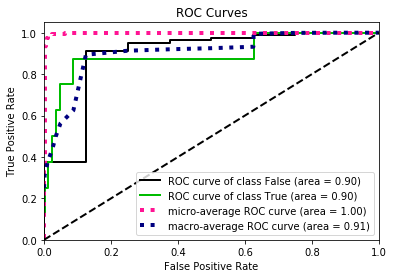

In [5]:
logistic = linear_model.LogisticRegression()

#Note:
# Because some businesses are not contained in the checkin dataset and some rows were dropped
# due to having None values in the precutoff time data after applying the Prediction Problem.
training_features = feature_matrix[feature_matrix.index.isin(first_label.business_id)]
training_labels = list(first_label['problem_label_excluding_data_post_cutoff_time'])
true_labels = first_label['problem_label_all_data']

logistic.fit(training_features, training_labels)
predicted_labels = logistic.predict(training_features)
predicted_probabilities = logistic.predict_proba(training_features)

accuracy = accuracy_score(true_labels, predicted_labels)
print("Classifier Accuracy: {0:.4f}".format(accuracy, prediction_problem))

accuracy_no_prediction = accuracy_score(training_labels, predicted_labels)
print("Baseline Accuracy Metric: {0:.4f}, based on using training_labels as the prediction".format(accuracy, prediction_problem))

skplt.metrics.plot_roc_curve(true_labels, predicted_probabilities)
plt.show()